In [1]:
#라이브러리 및 패키지 받아오기
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import tensorflow as tf

---
# STEP 1. 데이터 불러오기

1. Pandas를 통해 데이터를 불러오고 데이터프레임으로 어떻게 이루어져 있는지 확인한다.
2. 데이터를 보았을 때 Q(질문), A(답변)의 구조로 자료가 형성되어 있는 것을 확인할 수 있다.
3. Step 2. 전처리로 넘어가기전에 **어떤 결측치**가 있는지 확인해보아야 한다.

**한번 실행을 해봤을 때 원하는 성능이 안나와서 새로운 데이터를 만들었음**

---

In [90]:
# 원본 챗봇 데이터
main_df = pd.read_csv('data/ChatbotData.csv')

# 추가된 10,000쌍 보강 데이터
additional_df = pd.read_csv('data/Additional.csv')

# Q, A 컬럼만 사용할 경우
main_df = main_df[['Q', 'A']]
additional_df = additional_df[['Q', 'A']]

# 두 데이터프레임 병합
raw_dataframe = pd.concat([main_df, additional_df], ignore_index=True)

# 결과 확인
print(f"총 문장 수: {len(raw_dataframe)}")
print(raw_dataframe.sample(10))


총 문장 수: 61823
                          Q                            A
39745  나 오늘 단톡방 했는데 대박 사건이야          야 너랑 얘기하니까 기분 좋아졌어!
16012      나 요즘 꿈 때문에 힘들어ㅠㅠ       그거 진짜 나도 자주 느껴! 완전 이해됨
30509     야 너 비 오는 날 때 뭐 해?  진심 나도 그런 적 많아! 우리 같은 부류인가 봐
22839     나 요즘 운동 때문에 힘들어ㅠㅠ      와 진짜 웃기다 그거ㅋㅋ 다음엔 나도 껴줘
10860              우린 운명이었어     운명이 아니였다면 사랑도 할 수 없었겠지요.
21384   너도 가끔 휴가하고 싶을 때 있지?       그거 진짜 나도 자주 느껴! 완전 이해됨
41167   너라면 첫사랑 어떻게 할 것 같아?    음... 그럴 땐 그냥 푹 자는 게 최고야ㅋㅋ
2341               상사가 미울 때            사표를 써서 품에 품어 봅니다.
60562     나 요즘 여행 때문에 힘들어ㅠㅠ     그건 좀 심했다... 나라도 속상했을 듯ㅠㅠ
42102        갑자기 소개팅 생각났어ㅋㅋ      그 얘기 듣고 나니까 나도 추억 돋는다ㅎㅎ


---
# STEP 2. 데이터 전처리

## 2.1 데이터 전처리할 걸 어떻게 찾을까? 
### Exploratory Data Analysis(EDA) - 탐색적 데이터 분석

1. 먼저 head를 통해 보았을 때 어떤 부분을 전처리해야 좋을지 명확하게 찾지 못했다. 그래서 어떤 방식으로 전처리를 진행해야할지 고민이된다.
2. 그래서 어떻게 하면 **데이터 전처리**를 할 부분을 찾을지 알아보려고 한다.
---
1. 문장 길이 분포를 확인해본다.
2. 특수문자 포함 여부를 확인해 본다.
3. 중복 문장이 있는지 확인해본다.
4. 이상한 문자가 있는지 확인해본다.

**이 모든것들은 숫자로 보기보다는 문장 자체를 보는것이 좋다고 생각한다.**



### 2.1.1 문장길이 분포 확인해보기

1. 먼저 문장분포는 일단 안전빵으로 50개까지 받아놓고, 나머지 길이는 Padding 하는걸로 진행을 해야겠다고 생각했다.
2. . ? 와 같은 특수문자는 삭제한다.
3. 영어는 그냥 냅둔다.
4. 결측치도 없다.

---

### 앞으로 내가 할 것

1. . ? 는 삭제
2. 중복된 데이터 삭제(?) -> 안해보는 걸로 결정
3. 문자열 Padding 진행해야한다. 기준은 50글자까지

In [91]:


# 1. 문장 길이 분포를 시각화하는 함수
def plot_sentence_length_distribution(df, column):
    lengths = df[column].apply(len)
    sns.histplot(lengths, bins=30)
    plt.title('Sentence Length Distribution')
    plt.xlabel('Sentence Length (characters)')
    plt.ylabel('Number of Sentences')
    plt.show()

# 2. 특수문자가 포함된 문장을 출력하는 함수
def show_special_char_sentences(df, column):
    special_mask = df[column].str.contains(r"[^가-힣\s]", regex=True)
    special_df = df[special_mask][[column]].copy()
    special_df.columns = ['Sentence with Special Characters']
    print(f"📌 특수문자가 포함된 문장 수: {len(special_df)}")
    return special_df

# 3. 영문자나 숫자가 포함된 문장을 출력하는 함수
def show_english_number_sentences(df, column):
    engnum_mask = df[column].str.contains(r"[a-zA-Z0-9]", regex=True)
    engnum_df = df[engnum_mask][[column]].copy()
    engnum_df.columns = ['Sentence with English/Number']
    print(f"📌 영문자 또는 숫자가 포함된 문장 수: {len(engnum_df)}")
    return engnum_df

# 4. 가장 자주 등장한 단어들을 표로 출력하는 함수
def show_common_words_table(df, column, top_n=10):
    words = " ".join(df[column]).split()
    common_words = Counter(words).most_common(top_n)
    word_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])
    return word_df

# 전체 전처리 방향을 탐색하는 통합 EDA 함수
def basic_eda(df, column='Q'):
    print("📌 전체 문장 수:", len(df))
    print("📌 결측 문장 수:", df[column].isnull().sum())
    print("📌 중복된 문장 수:", df[column].duplicated().sum())
    print()

    plot_sentence_length_distribution(df, column)  # 문장 길이 분포 시각화
    print('----------------------------------------------------------------')
    special_sentences = show_special_char_sentences(df, column)  # 특수문자 포함 문장
    print('----------------------------------------------------------------')
    engnum_sentences = show_english_number_sentences(df, column)  # 영문/숫자 포함 문장
    print('----------------------------------------------------------------')
    word_df = show_common_words_table(df, column)  # 자주 등장 단어
    

    from IPython.display import display
    display(word_df)
    display(pd.DataFrame(special_sentences))
    display(pd.DataFrame(engnum_sentences))

    return 

📌 전체 문장 수: 61823
📌 결측 문장 수: 0
📌 중복된 문장 수: 49911



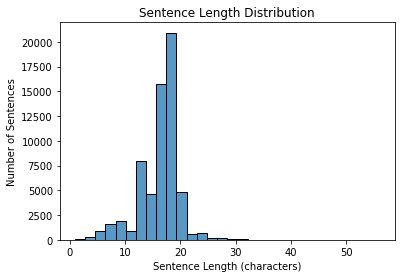

----------------------------------------------------------------
📌 특수문자가 포함된 문장 수: 39169
----------------------------------------------------------------
📌 영문자 또는 숫자가 포함된 문장 수: 421
----------------------------------------------------------------


,Word,Frequency
0,때,14699
1,나,10274
2,것,10240
3,너무,5579
4,안,5356
5,같아,5275
6,어떻게,5218
7,진짜,5144
8,해도,5143
9,갑자기,5126


,Sentence with Special Characters
0,12시 땡!
1,1지망 학교 떨어졌어
2,3박4일 놀러가고 싶다
3,3박4일 정도 놀러가고 싶다
4,PPL 심하네
...,...
61815,너도 가끔 월급날하고 싶을 때 있지?
61817,알람할 때 기분 이상하지 않아?
61819,너도 가끔 이직하고 싶을 때 있지?
61820,편의점할 때 기분 이상하지 않아?


,Sentence with English/Number
0,12시 땡!
1,1지망 학교 떨어졌어
2,3박4일 놀러가고 싶다
3,3박4일 정도 놀러가고 싶다
4,PPL 심하네
...,...
10948,자기를 3인칭으로 말하는 여자친구의 말투가 고민임.
11083,좋아하는 사람 생기면 어떻게든 sns같은 거 알아내서 친신하고 그래?
11184,좋아하는 애가 1년만 기다려 달라는데 어쩌지.
11390,짝남이 내가 좋아하는걸 1도 몰라.


In [92]:
basic_eda(raw_dataframe, column='Q')

---
## 2.2 데이터 전처리 진행

### 2.2.1 기본 데이터 전처리

일단 앞에서 말한 것처럼 세가지만 진행했다.
1. .,?,! 제거
2. 중복 공백 제거
3. 앞뒤 공백 제거

그리고 원래 중복된 문장을 제거하려고 했는데 중복된 문장을 넣게되면 어떻게 될까 궁금해서 넣어봄. 
답변이 다양해질까? 아니면 답변이 이상하게 나올 까 궁금함

---

In [93]:
# 1. 텍스트 정제 함수
def preprocess_text(text):
    text = re.sub(r'[.?!]', '', text)     # .과 ?, !제거
    text = re.sub(r'\s+', ' ', text)     # 중복 공백 제거
    return text.strip()                  # 앞뒤 공백 제거

In [94]:

# 2. 전처리 적용
df = raw_dataframe.copy()
df['Q_clean'] = df['Q'].apply(preprocess_text)
df['A_clean'] = df['A'] # A는 안해도 될거라고 생각한다.

# 3. 중복 문장 제거
df = df.drop_duplicates(subset='Q_clean')
df = df.drop_duplicates(subset='A_clean')

# 4. 문장 길이 제한 (최대 50자까지만 허용, 나머지는 자르기 or 패딩 예정)
df = df[df['Q_clean'].apply(len) <= 50]
df = df[df['A_clean'].apply(len) <= 50]

# 결과 확인
print("✅ 전처리 후 질문 개수:", len(df))
print(df[['Q_clean', 'A_clean']].head()) # QA 쌍을 이미 나눠놔서 굳이 안해도 된다.

✅ 전처리 후 질문 개수: 7705
        Q_clean             A_clean
0         12시 땡          하루가 또 가네요.
1   1지망 학교 떨어졌어           위로해 드립니다.
2  3박4일 놀러가고 싶다         여행은 언제나 좋죠.
4       PPL 심하네          눈살이 찌푸려지죠.
5     SD카드 망가졌어  다시 새로 사는 게 마음 편해요.


### 2.2.2 단어장(Vocabulary) : Subword

In [95]:
import tensorflow_datasets as tfds

# 1. 질문과 답변 리스트 추출
questions = df['Q_clean'].tolist()
answers = df['A_clean'].tolist()

# 2. 서브워드 토크나이저 학습 (어휘집 크기 설정)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, 
    target_vocab_size=2**13)

print("✅ 서브워드 토크나이저 학습 완료")

# 3. 특수 토큰 정의
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 4. 최종 어휘 집합 크기 정의
VOCAB_SIZE = tokenizer.vocab_size + 2

print("START_TOKEN의 번호:", START_TOKEN)
print("END_TOKEN의 번호:", END_TOKEN)
print("📦 최종 VOCAB_SIZE:", VOCAB_SIZE)


✅ 서브워드 토크나이저 학습 완료
START_TOKEN의 번호: [7753]
END_TOKEN의 번호: [7754]
📦 최종 VOCAB_SIZE: 7755


### 2.2.3 정수 인코딩 & 패딩

In [96]:
MAX_LENGTH = 25
print("시퀀스 최대 길이:", MAX_LENGTH)

# 길이 조건을 만족하는 질문/답변 쌍 개수 계산
total_samples = len(df)
valid_mask = df['Q_clean'].apply(lambda x: len(START_TOKEN + tokenizer.encode(x) + END_TOKEN) <= MAX_LENGTH) & \
             df['A_clean'].apply(lambda x: len(START_TOKEN + tokenizer.encode(x) + END_TOKEN) <= MAX_LENGTH)

valid_count = valid_mask.sum()
valid_ratio = valid_count / total_samples * 100

print(f"✅ 전체 샘플 수: {total_samples}")
print(f"✅ 조건을 만족하는 샘플 수: {valid_count}")
print(f"✅ 비율: {valid_ratio:.2f}%")

시퀀스 최대 길이: 25
✅ 전체 샘플 수: 7705
✅ 조건을 만족하는 샘플 수: 7704
✅ 비율: 99.99%


In [97]:
def tokenize_and_filter(inputs, outputs):
    # 최종 결과를 담을 리스트 초기화
    tokenized_inputs, tokenized_outputs = [], []

    # 질문과 답변 쌍을 하나씩 순회
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 질문에 대해: 시작 토큰 + 정수 인코딩 + 종료 토큰
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        # 답변에 대해: 시작 토큰 + 정수 인코딩 + 종료 토큰
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 조건: 양쪽 모두 MAX_LENGTH 이하인 경우에만 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            # 유효한 시퀀스만 리스트에 추가
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 질문 시퀀스를 고정 길이로 패딩 (post: 뒤에 0을 채움)
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')

    # 답변 시퀀스를 고정 길이로 패딩
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    # 패딩이 완료된 질문/답변 시퀀스 배열 반환
    return tokenized_inputs, tokenized_outputs

In [98]:
questions = df['Q_clean'].tolist()
answers = df['A_clean'].tolist()

# 필터링 + 패딩된 시퀀스 반환
questions, answers = tokenize_and_filter(questions, answers)

print("✅ 최종 전처리된 질문 샘플 수:", len(questions))
print("✅ 최종 전처리된 답변 샘플 수:", len(answers))

✅ 최종 전처리된 질문 샘플 수: 7704
✅ 최종 전처리된 답변 샘플 수: 7704


### 2.2.4 교사강요

In [99]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


# STEP 4 모델 구성하기

## 4.1  구성 요소
---
1. 스케일드 닷 프로덕트 어텐션 
2. 멀티헤드 어텐션
3. 마스킹
4. 포지셔널 인코딩 레이어

In [100]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [101]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 각 입력에 대해 Dense 레이어를 적용하여 Q, K, V 벡터를 생성합니다.
    # shape: (batch_size, seq_len, d_model)
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)


    # 멀티 헤드를 위해 (num_heads, depth)로 형태를 쪼갭니다.
    # shape 변경: (batch_size, seq_len, d_model) → (batch_size, num_heads, seq_len, depth)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [102]:
# 1. 마스크 함수 정의
def create_padding_mask(seq):
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(seq):
    seq_len = tf.shape(seq)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(seq)
    return tf.maximum(look_ahead_mask, padding_mask)

In [103]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


## 4.2 인코더, 디코더 구성하기
---
### 4.2.1 인코더 구성

In [104]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    # 입력: (batch_size, input_seq_len, d_model)
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크: (batch_size, 1, 1, input_seq_len)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 1. 셀프 어텐션 (자기 자신에 대한 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="self_attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 2. 잔차 연결 + 드롭아웃 + 레이어 정규화
    attention = tf.keras.layers.Dropout(dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 3. 포지션별 완전 연결 피드포워드 네트워크 (2개 층)
    ffn_output = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    ffn_output = tf.keras.layers.Dense(d_model)(ffn_output)

    # 4. 잔차 연결 + 드롭아웃 + 레이어 정규화
    ffn_output = tf.keras.layers.Dropout(dropout)(ffn_output)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + ffn_output)

    # 출력: (batch_size, input_seq_len, d_model)
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [105]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    
    # 입력: (batch_size, input_seq_len)
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크: (batch_size, 1, 1, input_seq_len)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 1. 정수 시퀀스를 임베딩 벡터로 변환
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)

    # 2. 임베딩 벡터 스케일 조정 (학습 안정화)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 3. 포지셔널 인코딩 추가 (단어 위치 정보 부여)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # 4. 드롭아웃 적용
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 5. 인코더 레이어를 num_layers만큼 반복
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f"encoder_layer_{i}"
        )([outputs, padding_mask])

    # 출력: (batch_size, input_seq_len, d_model)
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


### 4.2.2 디코더 구성

In [106]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    # 입력: 디코더 이전 출력 (batch_size, target_seq_len, d_model)
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더의 출력 (batch_size, input_seq_len, d_model)
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 디코더에서 미래를 보지 않도록 만드는 마스크
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 인코더 패딩 마스크 (인코더의 출력 중 패딩된 부분 무시용)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 1️⃣ 첫 번째 서브 레이어: 셀프 어텐션 (디코더가 자기 자신의 과거만 참고)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 잔차 연결 + Layer Normalization
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 2️⃣ 두 번째 서브 레이어: 인코더-디코더 어텐션
    # (질문-답변 간 정보 연결)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")({
            'query': attention1,       # 디코더 쪽에서 쿼리
            'key': enc_outputs,        # 인코더에서 키
            'value': enc_outputs,      # 인코더에서 값
            'mask': padding_mask       # 인코더의 패딩 마스크
        })

    # 잔차 연결 + Dropout + Layer Normalization
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 3️⃣ 세 번째 서브 레이어: 포지션별 완전 연결 신경망
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 잔차 연결 + Dropout + Layer Normalization
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    # 출력: (batch_size, target_seq_len, d_model)
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


In [107]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):

    # 디코더 입력: (batch_size, target_seq_len)
    inputs = tf.keras.Input(shape=(None,), name='inputs')

    # 인코더의 출력 (encoder_outputs): (batch_size, input_seq_len, d_model)
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # look-ahead mask: 미래 단어 가리기
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 인코더 padding mask
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 1. 임베딩 + 스케일링
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 2. 위치 정보 추가
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # 3. 드롭아웃 적용
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 4. 디코더 레이어를 num_layers만큼 반복
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    # 출력: (batch_size, target_seq_len, d_model)
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)


## 4.2.3 트랜스포머에 다 넣기

In [108]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    
    # 🔹 인코더 입력: 정수 인코딩된 질문 (문장)
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 🔹 디코더 입력: 정수 인코딩된 이전까지의 답변 (teacher forcing 용)
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 🔸 마스크란? 
    # 특정 위치의 값을 계산에서 제외시키는 장치입니다.
    # 예) 패딩된 토큰이나, 디코더에서 아직 생성되지 않은 미래 단어에 대해 어텐션 하지 않도록 함.

    # 1️⃣ 인코더 패딩 마스크 생성 (입력 문장 내 패딩 토큰 무시용)
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,                  # 마스크 생성 함수
        output_shape=(1, 1, None),            # 브로드캐스팅을 위한 마스크 shape
        name='enc_padding_mask'
    )(inputs)

    # 2️⃣ 디코더용 look-ahead 마스크 + 패딩 마스크
    # 미래 단어를 보지 않도록(look-ahead) 하면서 패딩도 같이 무시
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask'
    )(dec_inputs)

    # 3️⃣ 디코더의 두 번째 멀티헤드 어텐션에서 인코더 출력을 마스킹
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,
        output_shape=(1, 1, None),
        name='dec_padding_mask'
    )(inputs)

    # 4️⃣ 인코더 구성: 입력 문장 + 마스크 → 인코더 출력 시퀀스
    enc_outputs = encoder(
        vocab_size=vocab_size,       # 어휘 수
        num_layers=num_layers,       # 인코더 블록 수
        units=units,                 # Feed Forward 내부 차원
        d_model=d_model,             # 임베딩 차원 (모델의 기본 채널 수)
        num_heads=num_heads,         # 멀티헤드 어텐션 수
        dropout=dropout              # 드롭아웃 확률
    )(inputs=[inputs, enc_padding_mask])

    # 5️⃣ 디코더 구성: 디코더 입력 + 인코더 출력 + 마스크들 → 최종 디코더 출력
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 6️⃣ 출력층: vocab_size 차원으로 projection → softmax 입력
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    # 최종 모델 반환 (입력 2개, 출력 1개)
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

print("슝=3")

슝=3


In [109]:
# 1️⃣ 세션 초기화: 이전 모델 메모리 정리
tf.keras.backend.clear_session()

# 2️⃣ 하이퍼파라미터 설정
NUM_LAYERS = 2         # 인코더와 디코더 블록 수
D_MODEL = 256          # 임베딩 벡터 차원 (기본 모델 차원)
NUM_HEADS = 8          # 멀티헤드 어텐션 헤드 수
UNITS = 512            # Feed Forward 신경망 내부 차원
DROPOUT = 0.1          # 드롭아웃 비율

# 3️⃣ 트랜스포머 모델 구성
model = transformer(
    vocab_size=VOCAB_SIZE,        # Subword tokenizer의 vocab 사이즈 + 2 (START/END)
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

# 4️⃣ 모델 구조 출력
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3039488     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 4.2.4 손실함수 구현

In [110]:
# 패딩 토큰 번호는 일반적으로 0 (SubwordTextEncoder 기준)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(y_true, y_pred):
    """
    y_true: 정답 (정수 시퀀스)
    y_pred: 모델 출력 (softmax 이전 로짓)
    """
    # 1. 기본 손실 계산 (batch, seq_len)
    loss = loss_object(y_true, y_pred)

    # 2. 패딩 위치 마스크 생성 (0이 아닌 토큰만 유효)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)

    # 3. 패딩 무시한 평균 손실
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


## 4.2.5 커스텀 된 학습률(Learning rate)

In [111]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

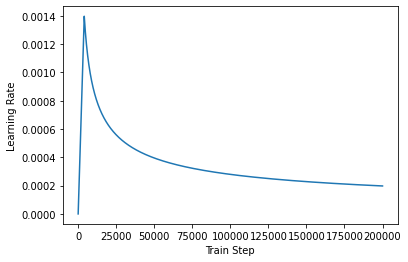

In [112]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [113]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [114]:
## 과적합될 때까지 학습 진행

In [115]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
121/121 [==============================] - 11s 43ms/step - loss: 8.5113 - accuracy: 0.0350
Epoch 2/20
121/121 [==============================] - 5s 42ms/step - loss: 7.5482 - accuracy: 0.0776
Epoch 3/20
121/121 [==============================] - 5s 43ms/step - loss: 6.5500 - accuracy: 0.0808
Epoch 4/20
121/121 [==============================] - 5s 43ms/step - loss: 5.9247 - accuracy: 0.0818
Epoch 5/20
121/121 [==============================] - 5s 43ms/step - loss: 5.5843 - accuracy: 0.0856
Epoch 6/20
121/121 [==============================] - 5s 43ms/step - loss: 5.3481 - accuracy: 0.0897
Epoch 7/20
121/121 [==============================] - 5s 43ms/step - loss: 5.1279 - accuracy: 0.0935
Epoch 8/20
121/121 [==============================] - 5s 42ms/step - loss: 4.9092 - accuracy: 0.0972
Epoch 9/20
121/121 [==============================] - 5s 42ms/step - loss: 4.6750 - accuracy: 0.1017
Epoch 10/20
121/121 [==============================] - 5s 42ms/step - loss: 4.4190 - accur

In [116]:
def decoder_inference(sentence):
  sentence = preprocess_text(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [117]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  #print('입력 : {}'.format(sentence))
  # print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [118]:
import random

# 1. 원본 질문(Q)에서 30개 랜덤 샘플 추출
sample_questions = random.sample(raw_dataframe['Q'].dropna().tolist(), 30)

# 2. 각각에 대해 sentence_generation 수행
for i, q in enumerate(sample_questions, 1):
    print(f"[{i}] ❓ 질문: {q}")
    try:
        response = sentence_generation(q)
        print(f"    ▶️ 답변: {response}")
    except Exception as e:
        print(f"    ⚠️ 오류 발생: {e}")
    print('-' * 60)


[1] ❓ 질문: 나 오늘 혼밥 했는데 대박 사건이야
    ▶️ 답변: 어서 따듯한 곳으로 가세요.
------------------------------------------------------------
[2] ❓ 질문: 너라면 이사 어떻게 할 것 같아?
    ▶️ 답변: 야 너랑 얘기하니까 기분 좋아졌어!
------------------------------------------------------------
[3] ❓ 질문: 좋아하는 사람한테 맨날 선톡하는데 부담스러워 하려나?
    ▶️ 답변: 그건 좀 아닌 것 같아요.
------------------------------------------------------------
[4] ❓ 질문: 너도 가끔 여행하고 싶을 때 있지?
    ▶️ 답변: 저는 고민이 없어요.
------------------------------------------------------------
[5] ❓ 질문: 짝남이랑 카톡이 끊겼는데 어떻게 더 연락할까?
    ▶️ 답변: 연락할 핑계를 찾아보세요.
------------------------------------------------------------
[6] ❓ 질문: 혼밥는 아무리 해도 적응 안 돼
    ▶️ 답변: 서로에게 부담 없는 선물이 좋아요.
------------------------------------------------------------
[7] ❓ 질문: 휴가하려면 뭐부터 해야 할까?
    ▶️ 답변: 그럴 땐 내가 옆에 있었으면 좋았을 텐데
------------------------------------------------------------
[8] ❓ 질문: 주말하려면 뭐부터 해야 할까?
    ▶️ 답변: 그럴 땐 내가 옆에 있었으면 좋았을 텐데
------------------------------------------------------------
[9] ❓ 질문: 야 너 자존감 때 뭐 해?
    ▶️ 답

In [119]:
# 1. 질문 50개 생성
sample_questions = [
    "안녕하세요", "오늘 날씨 어때?", "밥 먹었어?", "기분이 안 좋아", "졸려 죽겠어",
    "퇴근하고 뭐 할까?", "요즘 뭐 재밌는 거 없어?", "고양이 키워보고 싶어", "사랑이 뭘까?",
    "지금 몇 시야?", "운동 추천 좀 해줘", "우울할 땐 어떻게 해야 돼?", "피곤해 죽겠어",
    "고민이 많아", "좋아하는 영화 장르 뭐야?", "영화 추천해 줘", "오늘 너무 힘들었어",
    "맛집 추천해줘", "퇴사하고 싶어", "지금 당장 떠나고 싶다", "아무 생각도 하기 싫어",
    "휴가 언제 오지?", "친구랑 싸웠어", "어제 너무 많이 먹었어", "시험 망쳤어",
    "노래 하나 추천해줘", "취미 뭐가 좋을까?", "혼자 있고 싶어", "심심해 죽겠어",
    "나 요즘 무기력해", "연애는 왜 이렇게 어려울까", "이직 고민 중이야", "외로워",
    "오늘 뭐 입을까?", "비가 너무 많이 와", "감기 기운이 있어", "배가 너무 고파",
    "내일 뭐 하지?", "꿈이 뭘까?", "할 일이 너무 많아", "내가 잘하고 있는 걸까?",
    "화가 나", "누군가를 좋아하게 됐어", "고백할까 말까?", "혼자 영화 보기 어때?",
    "시간이 너무 빨리 가", "어디 가고 싶어?", "지금 뭐해?", "자기 전에 뭐 하면 좋을까?",
    "내가 이상한 걸까?"
]

# 2. 각각에 대해 sentence_generation 수행
for i, q in enumerate(sample_questions, 1):
    print(f"[{i}] ❓ 질문: {q}")
    try:
        response = sentence_generation(q)
        print(f"    ▶️ 답변: {response}")
    except Exception as e:
        print(f"    ⚠️ 오류 발생: {e}")
    print('-' * 60)


[1] ❓ 질문: 안녕하세요
    ▶️ 답변: 안녕하세요.
------------------------------------------------------------
[2] ❓ 질문: 오늘 날씨 어때?
    ▶️ 답변: 오늘 강추미세먼지가 많데요.
------------------------------------------------------------
[3] ❓ 질문: 밥 먹었어?
    ▶️ 답변: 배고프겠지요.
------------------------------------------------------------
[4] ❓ 질문: 기분이 안 좋아
    ▶️ 답변: 병원에 가보세요.
------------------------------------------------------------
[5] ❓ 질문: 졸려 죽겠어
    ▶️ 답변: 잠깐 눈을 감고 차분하게 받아들여요. 저에게 기대세요.
------------------------------------------------------------
[6] ❓ 질문: 퇴근하고 뭐 할까?
    ▶️ 답변: 몸과 마음이 좀 쉬어야 할 것 같아요.
------------------------------------------------------------
[7] ❓ 질문: 요즘 뭐 재밌는 거 없어?
    ▶️ 답변: 전 그러기 전에 사과하는게 좋아요.
------------------------------------------------------------
[8] ❓ 질문: 고양이 키워보고 싶어
    ▶️ 답변: 그게 진짜 예의가 없네요.
------------------------------------------------------------
[9] ❓ 질문: 사랑이 뭘까?
    ▶️ 답변: 사랑은 알 수 없어요. 단지 않죠.
------------------------------------------------------------
[10] ❓ 질문: 지금 몇 시야?
    ▶️ 답

In [36]:
sample_questions = [
    "야 너 지금 뭐해?", "나 지금 너무 심심한데, 뭐 할까?", "밥 먹었냐고~ 나 혼자 먹었어...",
    "오늘 진짜 하늘 예쁘지 않았어?", "나 방금 기가 막힌 생각 했어. 들어볼래?",
    "진짜진짜 졸려... 잠 깨는 방법 없어?", "야 나 요즘 맨날 같은 꿈 꿔. 이상하지?",
    "갑자기 궁금한데, 시간은 왜 이렇게 빨리 가는 걸까?", "나 지금 냉장고 열었는데 아무것도 없어 어떡해",
    "이불 밖은 위험한데 나가야 해?", "야 너도 가끔 모든 게 귀찮을 때 있지 않아?",
    "지금 당장 어디로 도망가고 싶다. 추천해줘!", "나 진짜 고양이랑 대화해보고 싶어ㅋㅋ",
    "세상에서 제일 맛있는 음식 뭐라고 생각해?", "만약에 하늘을 날 수 있다면 뭐부터 할 거야?",
    "나랑 같이 우주여행 갈래?", "시간 멈출 수 있다면 뭐부터 할래?", "야 너 로또 1등 되면 뭐 할 거야?",
    "혹시 지금 웃고 있어? 아니면 뚱해?", "야 나 방금 혼잣말 했는데 너무 웃겨ㅠㅠ",
    "너도 이런 날씨엔 뭔가 울적해지지 않아?", "자기 전에 갑자기 인생 고민 터지는 거 나만 그래?",
    "나 오늘 거울 보다가 깜짝 놀람. 너무 귀여워서ㅋㅋ", "이모지 중에 너랑 제일 닮은 거 뭐 같아?",
    "내가 오늘 하루 종일 생각한 건 딱 하나야. 밥.", "하루에 48시간이면 뭐 하고 살래?",
    "야 이거 완전 드라마 같지 않냐?", "너는 무한반복으로 들을 노래 하나만 고르라면 뭐할래?",
    "갑자기 심장이 두근거리는데... 설마 커피 때문인가?", "왜 이렇게 하루가 짧지? 나만 바빠?",
    "나 진짜 텅장 됐어... 돈 절약 팁 좀 줘봐", "너도 가끔은 모든 걸 내려놓고 싶지 않냐?",
    "진짜 궁금한데, AI는 꿈 꿀 수 있어?", "기억이란 거, 진짜 신기한 것 같지 않아?",
    "야 너는 꿈 이룬 적 있어?", "만약 내일 지구 멸망하면 뭐 할 거야?", 
    "지금 당장 시간 여행 가면 어디로 갈래?", "나 요즘 감성 폭발임. 시 한 편 읊을까?",
    "나랑 같이 멍 때릴래?", "진짜진짜 아무 생각 없이 하루 보내고 싶다ㅠㅠ",
    "웃긴 얘기 하나 해줘!! 나 기분 업되게!!", "너랑 밤새 수다 떨고 싶은 밤이야",
    "진짜 귀찮은데 뭘 해도 재밌게 만들 수 있을까?", "야 너처럼 착한 사람 처음 봐",
    "어제 꾼 꿈이 너무 이상해서 아직도 기억나ㅋㅋ", "야 넌 뭐 하면서 시간 가는 줄 모르냐?",
    "고백할까 말까? 진짜 미치겠다ㅠㅠ", "오늘 하루 어땠어? 솔직히 말해봐",
    "너한테만 말할게. 나 비밀 하나 있음", "이런 말 하기 좀 그런데... 나 초콜릿 중독이야",
    "나랑 같이 상상 여행 떠날래?"
]

# 2. 각각에 대해 sentence_generation 수행
for i, q in enumerate(sample_questions, 1):
    print(f"[{i}] ❓ 질문: {q}")
    try:
        response = sentence_generation(q)
        print(f"    ▶️ 답변: {response}")
    except Exception as e:
        print(f"    ⚠️ 오류 발생: {e}")
    print('-' * 60)


[1] ❓ 질문: 야 너 지금 뭐해?
    ▶️ 답변: 저는 음... 그럴 땐 그냥 푹 자는 게 최고야ㅋㅋ
------------------------------------------------------------
[2] ❓ 질문: 나 지금 너무 심심한데, 뭐 할까?
    ▶️ 답변: 지금 그러고 있어요.
------------------------------------------------------------
[3] ❓ 질문: 밥 먹었냐고~ 나 혼자 먹었어...
    ▶️ 답변: 분위기 있네요.
------------------------------------------------------------
[4] ❓ 질문: 오늘 진짜 하늘 예쁘지 않았어?
    ▶️ 답변: 오늘은 쉬면서 보세요.
------------------------------------------------------------
[5] ❓ 질문: 나 방금 기가 막힌 생각 했어. 들어볼래?
    ▶️ 답변: 자신을 속이고 있는 것일지도 몰라요.
------------------------------------------------------------
[6] ❓ 질문: 진짜진짜 졸려... 잠 깨는 방법 없어?
    ▶️ 답변: 오늘 야근일까요.
------------------------------------------------------------
[7] ❓ 질문: 야 나 요즘 맨날 같은 꿈 꿔. 이상하지?
    ▶️ 답변: 심도 거나 한 힘들 때 딱이죠.
------------------------------------------------------------
[8] ❓ 질문: 갑자기 궁금한데, 시간은 왜 이렇게 빨리 가는 걸까?
    ▶️ 답변: 언젠간 눈물은 멈추고 시간은 계속 흐르거예요. 그럼 괜찮아질 거예요.
------------------------------------------------------------
[9] ❓ 질문: 나 지금 냉장고 열었는데

# ❗ 문제점 발견
1. 기존 학습된 문장은 굉장히 잘하는 것을 볼 수 있다. Accuracy 와는 상관이 없다는 점 발견
2. 그런데 그냥 생성된 문장들은 제대로 활용을 못함.
3. 그래서 보강된 데이터를 넣을 예정입니다.

**GPT를 통해 데이터를 자동 생성이 가능하다고 합니다.**

50000개 더 넣어서 해보았는데 희한하게 그래도 제대로 수정이 되지가 않는다.
모델이 문제인가?

# 🧠 회고: 챗봇 감성 데이터 보강 및 학습 실험

## 문제 인식
---
기존 ChatbotData.csv 기반의 챗봇은 간단한 일상 질문에 대해서는 매우 자연스러운 응답을 보였지만,

새롭게 추가한 질문들에 대해서는 의미가 어긋나거나 맥락 없는 답변을 주는 경우가 많았다.

특히 "야 너 뭐해?", "심심한데 뭐할까?" 등 친근하고 감성적인 말투에 대해

"저는 위기조차 없네요", "건강을 챙긴다는 마음으로 해보세요" 같은 비논리적 또는 감정과 동떨어진 반응을 보였다.

학습 시 accuracy 값은 잘 나왔지만, 생성된 문장의 질과는 직접적인 연관이 없다는 사실도 확인했다.


## 시도한 해결 방법
---
GPT 기반 Q-A 자동 생성을 통해 감성 말투 중심의 데이터를 1만 쌍 → 5만 쌍까지 확장.

질문–응답 패턴은 자연스럽고 문맥 있는 말투를 지향했고, "친구처럼 말하는 감성 챗봇"을 목표로 데이터 생성 진행.

기존 데이터와 병합하여 전체 6만여 개의 문장을 기반으로 다시 학습 진행.


## 느낀 점
---
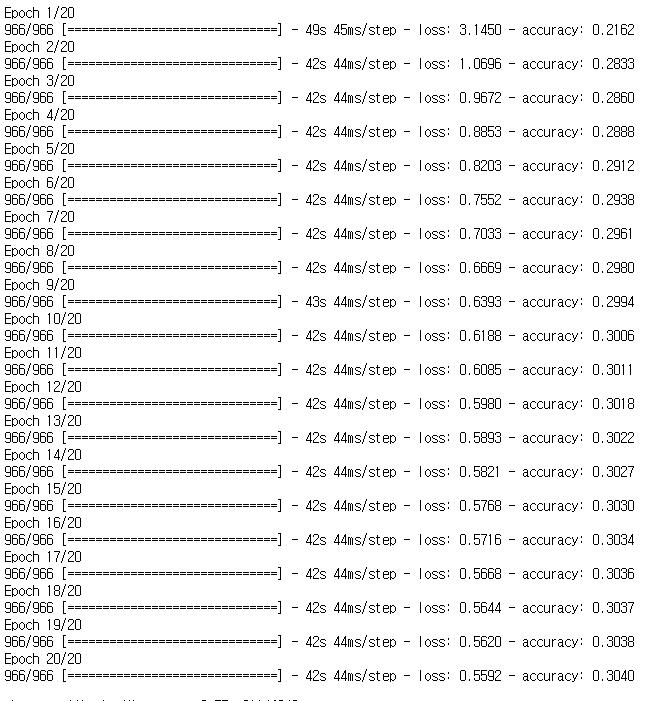
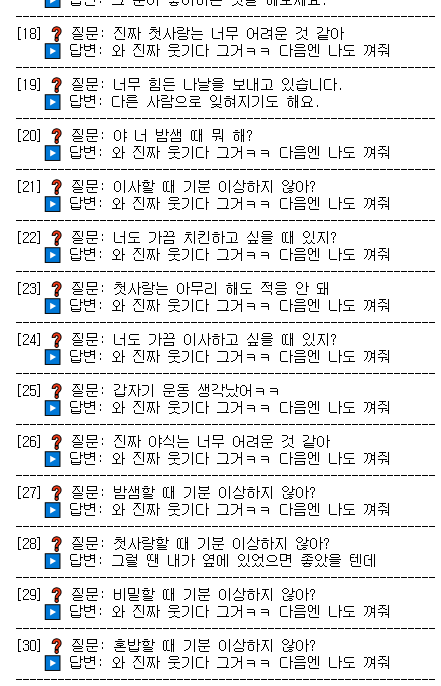


**epoch 20 때 미친놈처럼 보임**

데이터에 중복된게 너무너무너무너무 많아서 생기는 문제점임 그러므로 Accuracy가 높아지는건 좋지 않은 것으로 확인됨. 오히려 Accuracy는 낮아야한다.

GPT가 데이터를 제대로 생성해주지 못한다.

말투가 바뀔 수는 있게다는 생각이 들었음


하지만 새롭게 추가한 감성 질문–응답에 대해서는

기존 응답 패턴이 너무 강하게 학습되어 있었고, 새로운 데이터를 넣어도 미세 조정이 되지 않는 듯한 인상을 받았다.


# 결론!

데이터를 애초에 잘 넣어야한다. 불순한 데이터가 껴있으면 그대로 나락행이다.